# EN ESTA NOTEBOOK SE IMPLEMENTARÁ UN ARBOL DE DECISIÓN Y SE EVALUARÁN LOS RESULTADOS PARA EL PROYECTO





## ARBOLES DE DECISIÓN

In [102]:
#importanción de librerías a utilizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#ARBOL DE DECISIÓN
from sklearn.tree import DecisionTreeClassifier   #usqar arbol de decision
from sklearn.model_selection import train_test_split    #permite dividir dataset
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score, confusion_matrix 
from sklearn.preprocessing import StandardScaler #  librería para escalar las variables independientes
from sklearn.model_selection import GridSearchCV #para optimizar hiperparámetros

In [103]:
# IMPORTACIÓN DEL DATASET REDUCIDO LUEGO DEL PROCESAMIENTO DE COLUMNAS

df = pd.read_csv('friesgo_2018_reduc.csv',  sep=',', encoding='utf-8')

df.head(5)

,id,region,tamanio_aglomerado,tipo_vivienda,obtiene_gas,obtiene_agua,baño,cant_componentes,tipo_hogar,ingresos,...,altura_cm,considera_su_alimentacion,promedio_fv_diario,consumo_5porc_fv,colesterol_alto,consumido_alcohol,consumo_regular_riesgo,dijeron_diabetes,familiares_directos_diabetes,familiares_no_directos_diabetes
0,1128639,1,1,3,1,1,1,2,2,50000,...,181.0,2,4.00,2,2,1,2.0,2,2,2
1,1709939,1,1,1,1,1,1,3,4,40000,...,160.0,2,6.43,1,1,1,2.0,2,2,2
2,6874130,1,1,3,1,1,1,2,2,40000,...,160.0,2,2.86,2,2,1,2.0,2,2,2
3,10319375,1,1,3,4,1,1,1,1,80000,...,155.0,2,1.43,2,1,1,2.0,2,2,1
4,11140857,1,1,3,1,1,1,2,8,30000,...,178.0,2,1.43,2,2,1,2.0,2,2,99


In [104]:
df.columns

Index(['id', 'region', 'tamanio_aglomerado', 'tipo_vivienda', 'obtiene_gas',
       'obtiene_agua', 'baño', 'cant_componentes', 'tipo_hogar', 'ingresos',
       'asignaciones', 'sexo', 'edad', 'situacion_conyugal',
       'nivel_instruccion', 'cobertura_salud_nueva', 'ansiedad_depresion',
       'af_intensa_veces_por_semana', 'af_intensa_min_totales_por_semana',
       'af_intensa_min_totales_por_semana_nsnc',
       'af_moderada_veces_por_semana', 'af_moderada_min_totales_por_semana',
       'actividad_fisica_moderada_min_totales_por_semana_nsnc',
       'caminata_veces_por_semana', 'caminata_min_totales_por_semana',
       'caminata_min_totales_por_semana_nsnc', 'tiempo_sentado_min_por_dia',
       'tiempo_sentado_min_por_dia_nsnc', 'af_fue_actividad_domestica',
       'af_fue_actividad_laboral', 'af_fue_traslado', 'af_fue_deporte',
       'nivel_actividad_fisica', 'alguna_vez_fumo', 'edad_fumo_primera_vez',
       'No_sabe_edad_fumo_primera_vez', 'actualmente_fuma_cigarrillos',
    

In [105]:
#muevo columnas de variables dependiendtes al final

cols_to_move = [ 'veces_presion_alta', 'colesterol_alto', 'dijeron_diabetes']

df = df[[col for col in df if col not in cols_to_move] + cols_to_move]

print (df.iloc[:,-4:-1]) 

       familiares_no_directos_diabetes  veces_presion_alta  colesterol_alto
0                                    2                   3                2
1                                    2                   3                1
2                                    2                   3                2
3                                    1                   3                1
4                                   99                   3                2
...                                ...                 ...              ...
25632                                1                   3                2
25633                                2                   2                1
25634                                2                   2                1
25635                                1                   3                2
25636                               99                   2                2

[25637 rows x 3 columns]


In [106]:
# Lista de las regiones únicas
regiones = df['region'].unique()
print(regiones)



[1 2 3 4 5 6]


In [107]:
# Crear un diccionario para almacenar los DataFrames por región
dfs_por_region = {}




In [108]:
# Iterar sobre cada región y guardar un nuevo DF por cada una

for region in regiones:
    # Filtrar los datos por la región actual
    df_region = df[df['region'] == region]
    # Guardar el DataFrame en el diccionario usando la región como clave
    dfs_por_region[region] = df_region

In [109]:

#funcion para calcular metricas

def metricas(y_pred, y_test, enfermedad, region_actual):
        global result_dict
        exactitud = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        sensibilidad = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        confusion = confusion_matrix(y_test, y_pred)

        # Inicializar las claves si no existen
        if enfermedad not in result_dict:
            result_dict[enfermedad] = {}
        if region_actual not in result_dict[enfermedad]:
            result_dict[enfermedad][region_actual] = {}
        
        
        result_dict[enfermedad][region_actual]={
            'exactitud':exactitud,
            'precision':precision,
            'sensibilidad':sensibilidad,
            'f1': f1,
            'confusion': confusion
        }
        
        
        

In [110]:
# Crear diccionarios para almacenar modelos y resultados por región
modelos_por_region = {}
resultados_por_region = {}
importancia_por_region = {}

result_dict={}

# Iterar sobre cada región para entrenar y evaluar modelos
for region in regiones:
    # Obtener el DataFrame de la región actual
    df_region = dfs_por_region[region]
    
    # Variables independientes
    X_region = df_region.iloc[:, 1:-3]  # Todas las columnas menos las últimas tres y la primera (id)
    
    # Variables dependientes
    y_region_colesterol = df_region['colesterol_alto']
    y_region_diabetes = df_region['dijeron_diabetes']
    y_region_hipertension = df_region['veces_presion_alta']

    # Dividir los datos en conjuntos de entrenamiento y prueba para cada enfermedad
    X_train_col, X_test_col, y_train_col, y_test_col = train_test_split(X_region, y_region_colesterol, test_size=0.25, random_state=0)
    X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X_region, y_region_diabetes, test_size=0.25, random_state=0)
    X_train_hip, X_test_hip, y_train_hip, y_test_hip = train_test_split(X_region, y_region_hipertension, test_size=0.25, random_state=0)
    
    # Crear y entrenar el modelo de árbol de decisión para cada enfermedad
    clf_col = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=4)
    clf_col.fit(X_train_col, y_train_col)
    
    clf_dia = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=4)
    clf_dia.fit(X_train_dia, y_train_dia)
    
    clf_hip = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=4)
    clf_hip.fit(X_train_hip, y_train_hip)

  
    # Almacenar los modelos y sus resultados por región
    modelos_por_region[region] = {
        'colesterol': clf_col,
        'diabetes': clf_dia,
        'hipertension': clf_hip
    }

         
    #importancia de cada columna en el modelo entrenado
    importances_col = clf_col.feature_importances_
    importances_dia = clf_dia.feature_importances_
    importances_hip = clf_hip.feature_importances_
    
    importancia_por_region[region]={
        'colesterol': importances_col,
        'diabetes': importances_dia,
        'hipertension': importances_hip  
    }
      
        
    # Probar modelo con conjunto de prueba
    y_pred_col = clf_col.predict(X_test_col)
    y_pred_dia = clf_dia.predict(X_test_dia)
    y_pred_hip = clf_hip.predict(X_test_hip)
  
    
    
    ## METRICAS DE EVALUACIÓN   ##############33
    metricas(y_pred_col, y_test_col, 'colesterol', region)
    metricas(y_pred_dia, y_test_dia, 'diabetes', region)
    metricas(y_pred_hip, y_test_hip, 'hipertension', region)
    



  ## IMPRIMIMOS EXACTITUD, PRECISIÓN, SENSIBILIDAD, F1-Score Y MATRIZ DE CONFUSIÓN POR CADA MODELO

In [111]:
region_dict = {
    1: 'Metropolitana',
    2: 'Pampeana',
    3: 'Noroeste',
    4: 'Noreste',
    5: 'Cuyo',
    6: 'Patagónica'
}



In [112]:
# Mostrar los resultados
#for region, resultados in resultados_por_region.items():
for enfermedad, regiones in result_dict.items():
    for region, resultados in regiones.items():

        nombre_region = region_dict.get(region, f"Región {region}")
        print(f"Enfermedad: {enfermedad}")
        print(f"Región: {nombre_region}")
        print(f"Exactitud del modelo: {resultados['exactitud']:.4f}")
        print(f"Precision del modelo: {resultados['precision']:.4f}")
        print(f"Sensibilidad del modelo: {resultados['sensibilidad']:.4f}")
        print(f"f1 del modelo: {resultados['f1']:.4f}")
        print(f"Matriz de confusion del modelo: \n{resultados['confusion']}\n")

    
#    print(f"Exactitud del modelo para diabetes: {resultados['diabetes']:.4f}")
#    print(f"Exactitud del modelo para hipertensión: {resultados['hipertension']:.4f}\n")
    
    

Enfermedad: colesterol
Región: Metropolitana
Exactitud del modelo: 0.7346
Precision del modelo: 0.5396
Sensibilidad del modelo: 0.7346
f1 del modelo: 0.6222
Matriz de confusion del modelo: 
[[  0 215]
 [  0 595]]

Enfermedad: colesterol
Región: Pampeana
Exactitud del modelo: 0.7890
Precision del modelo: 0.6246
Sensibilidad del modelo: 0.7890
f1 del modelo: 0.6972
Matriz de confusion del modelo: 
[[   0  434]
 [   3 1634]]

Enfermedad: colesterol
Región: Noroeste
Exactitud del modelo: 0.7794
Precision del modelo: 0.7197
Sensibilidad del modelo: 0.7794
f1 del modelo: 0.7273
Matriz de confusion del modelo: 
[[ 28 216]
 [ 41 880]]

Enfermedad: colesterol
Región: Noreste
Exactitud del modelo: 0.7989
Precision del modelo: 0.7487
Sensibilidad del modelo: 0.7989
f1 del modelo: 0.7542
Matriz de confusion del modelo: 
[[ 24 147]
 [ 30 679]]

Enfermedad: colesterol
Región: Cuyo
Exactitud del modelo: 0.7368
Precision del modelo: 0.6907
Sensibilidad del modelo: 0.7368
f1 del modelo: 0.6664
Matriz d

## Conclusiones de análisis de los modelos:

<u>RESPECTO A COLESTEROL<u>
1. En general se observa que la mayoría de las MC (matriz de confusión) tienen muchos VERDADEROS POSITIVOS y pocos FALSOS NEGATIVOS  lo que indica que se predice correctamente a alguien con alto colesterol (buena sensibilidad) pero casi no se identifican VERDADEROS NEGATIVOS  (baja precisión)
2. Se podría pensar que las variables que determinan colesterol o no tal vez están relacionadas correctamente con la determinación del colesterol pero no son tan determinantes ya que no preicen correctamente el no coleterol
    
<u>RESPECTO A DIABETES<u>
1. Todos los modelos tienen una muy alta exactitud (>0.8) es decir que predice correctamente los positivos y negativos y también sensibilidad y precisión
2. Se observan valores considerables en FP(falsos positivos) por lo que es entendible que celda de VERDADEROS NEGATIVOS no tenga muchos valores (igualmente no son tan bajos como en colesterol)


<u>RESPECTO A HIPERTENSIÓN<u>
1. Se observa mayor proporción de valores VERDADERO POSITIVO Y VERDADERO NEGATIVO pero sin embargo las metricas tienen bajos resultados ya que se observa que también hay considerables FALSOS POSITIVOS Y FALSOS NEGATIVOS (baja precisión, baja sensibilidad, etc)
    
  

 ## IMPRIMIMOS IMPORTANCIA DE CADA COLUMNA

### COLESTEROL

In [113]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_colesterol_df = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_col = importancias['colesterol']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_col)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_col[i] > 0.03:  # solo imprimo columnas con importancia mayor a 0
                                 
            print(f"{columnas_originales[i]}: {importances_col[i]:.4f}")
            
            importancias_colesterol_df = importancias_colesterol_df.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_col[i]     
            }, ignore_index=True)
            
    print("\n")    
    
    

Región: Metropolitana
edad: 0.6222
profesional_indica_sobrepeso: 0.1048
ingresos: 0.0494
cobertura_salud_nueva: 0.0427
altura_cm: 0.0385
peso_kg: 0.0369
af_moderada_veces_por_semana: 0.0335


Región: Pampeana
edad: 0.6304
profesional_indica_sobrepeso: 0.2290
edad_fumo_primera_vez: 0.0348
ingresos: 0.0306


Región: Noroeste
edad: 0.5375
profesional_indica_sobrepeso: 0.3056
cobertura_salud_nueva: 0.0418


Región: Noreste
edad: 0.5431
profesional_indica_sobrepeso: 0.2545
tipo_hogar: 0.0345
peso_kg: 0.0336


Región: Cuyo
edad: 0.5537
profesional_indica_sobrepeso: 0.2254
peso_kg: 0.0493


Región: Patagónica
edad: 0.6093
profesional_indica_sobrepeso: 0.2089
tiempo_sentado_min_por_dia: 0.0464
caminata_min_totales_por_semana: 0.0459




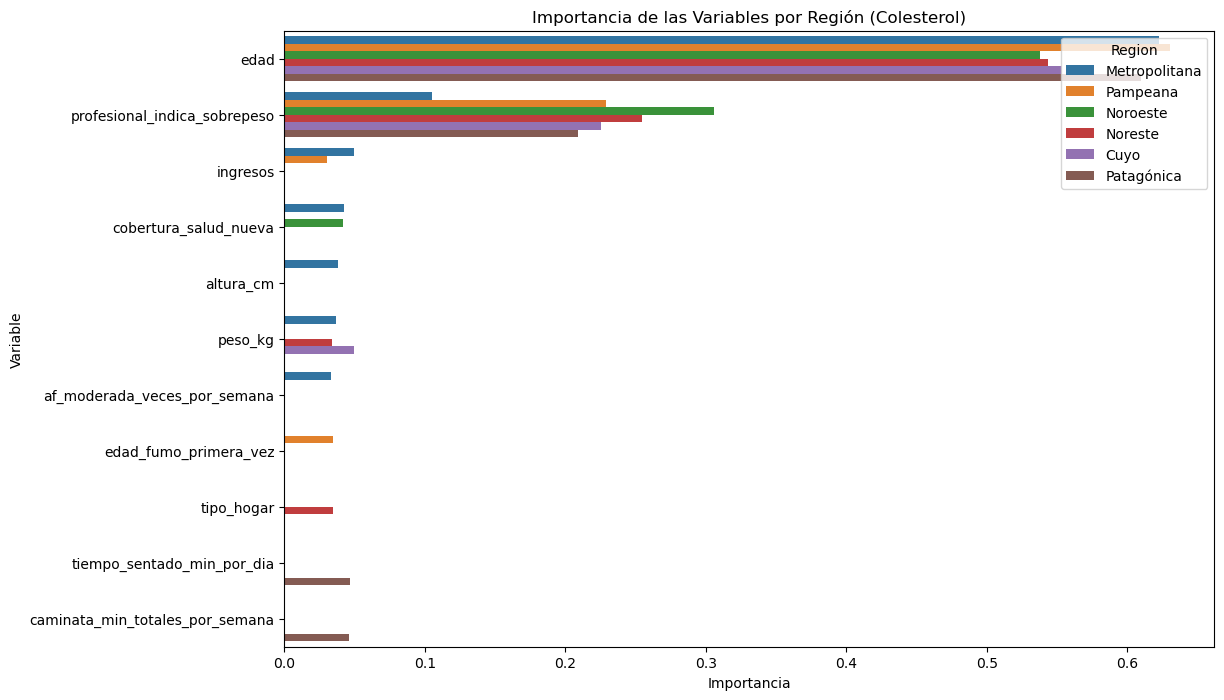

In [114]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_colesterol_df)
plt.title('Importancia de las Variables por Región (Colesterol)')
plt.show()

# Conclusiones: 

1. Se observa que de forma previsible la edad y el sobrepeso son factores importantes en cualquier región.
2. En la región PATAGÖNICA aparece com un factor importante la cantidad de minutos sentado y caminata. Se debe realizar un análisis en profundidad para determinar los valores en estas variables, pero considerando el clima un poco más hostil en esta región podría inferirse que hay diferencias importantes en este aspecto.
3. El ingreso parece ser una variables de gran importancia en el área metropolitana indicando que pueden haber diferencias significativas en este aspecto.
4. Tanto en el área Metropolitana como en el Noreste se observa que el tipo de cobertura de salud es significativo.

### HIPERTENSIÓN

In [115]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_hipertension_df = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_hip = importancias['hipertension']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_hip)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_hip[i] > 0.025:  # solo imprimo columnas con importancia mayor a 0
                    
            print(f"{columnas_originales[i]}: {importances_hip[i]:.4f}")
            
            importancias_hipertension_df = importancias_hipertension_df.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_hip[i]     
            }, ignore_index=True)
            
    print("\n") 






Región: Metropolitana
edad: 0.6146
peso_kg: 0.1434
ingresos: 0.0557
tiempo_sentado_min_por_dia: 0.0450
profesional_indica_sobrepeso: 0.0436
promedio_fv_diario: 0.0291
af_intensa_min_totales_por_semana: 0.0288


Región: Pampeana
edad: 0.7530
profesional_indica_sobrepeso: 0.1298
peso_kg: 0.0571


Región: Noroeste
edad: 0.6827
profesional_indica_sobrepeso: 0.1438
familiares_directos_diabetes: 0.0383
situacion_conyugal: 0.0260


Región: Noreste
edad: 0.6659
profesional_indica_sobrepeso: 0.1654
peso_kg: 0.0329
sexo: 0.0324
altura_cm: 0.0292


Región: Cuyo
edad: 0.6212
profesional_indica_sobrepeso: 0.1789
nivel_instruccion: 0.0328
peso_kg: 0.0304
ingresos: 0.0275
altura_cm: 0.0270


Región: Patagónica
edad: 0.6162
peso_kg: 0.1111
profesional_indica_sobrepeso: 0.1061
nivel_instruccion: 0.0391
caminata_veces_por_semana: 0.0270
situacion_conyugal: 0.0261




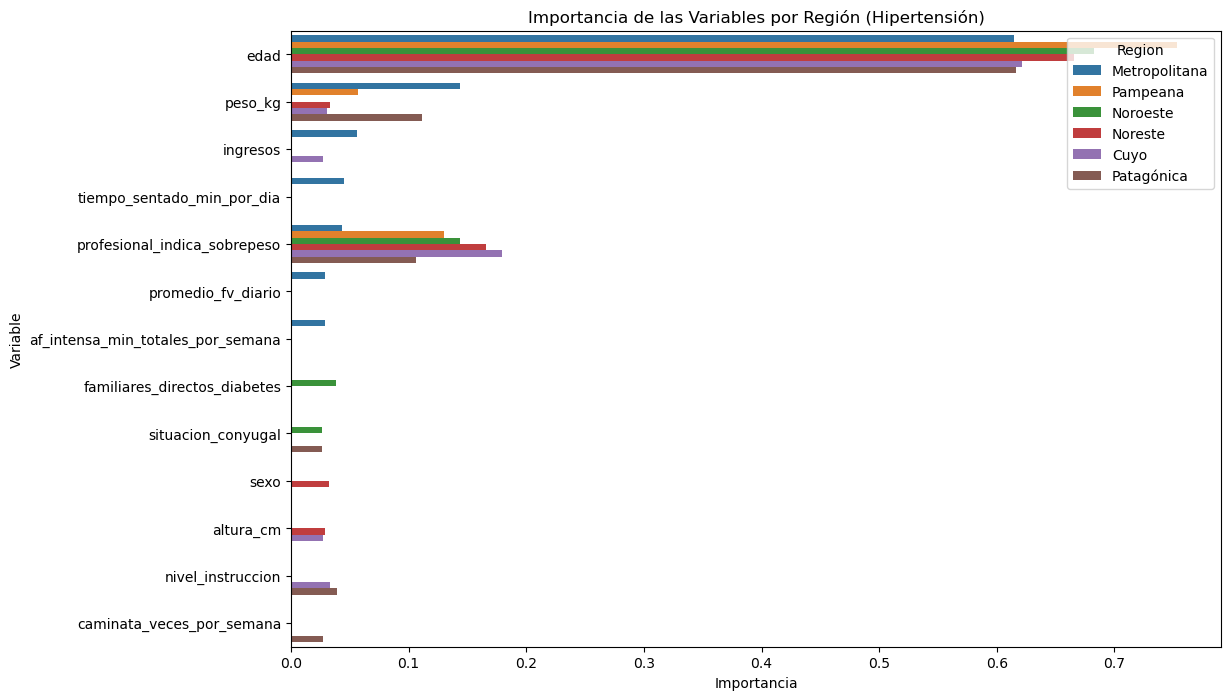

In [116]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_hipertension_df)
plt.title('Importancia de las Variables por Región (Hipertensión)')
plt.show()

# Conclusiones causas Hipertensión: 

1. Nuevamente se observa que la edad y el sobrepeso son variables importantes y generales en todas las regiones
2. En el Noroeste aparece como significativa la ocurrencia de familiares con diabetes en la determinación lo cual resulta llamativo ya que se está determinando la hipertensión. 
3. En el área Metropolitana, nuevamente el nivel de ingresos resultan significativos indicando diferencias importantes en este aspecto. Aparece también la cantidad de minutos sentado por día
4. Se observa en el Noreste una diferencia entre sexos
5. En cuyo y la patagonia el nivel de instrucción es significativo en la determinación de la hipertensión, tal vez por el tipo de trabajos u horas trabajadas, resposabilidades, etc.


### DIABETES

In [117]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_diabetes_df = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])

for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_dia = importancias['diabetes']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_dia)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
   
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_dia[i] > 0.04:  # solo imprimo columnas con importancia mayor a 0
            print(f"{columnas_originales[i]}: {importances_dia[i]:.4f}")
            
            importancias_diabetes_df = importancias_diabetes_df.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_dia[i]     
            }, ignore_index=True)
    print("\n")


Región: Metropolitana
edad: 0.2823
familiares_directos_diabetes: 0.2326
peso_kg: 0.1405
familiares_no_directos_diabetes: 0.0903
tipo_hogar: 0.0768
nivel_instruccion: 0.0731
caminata_veces_por_semana: 0.0484


Región: Pampeana
profesional_indica_sobrepeso: 0.3493
edad: 0.2753
familiares_directos_diabetes: 0.2041
peso_kg: 0.0545
altura_cm: 0.0424


Región: Noroeste
profesional_indica_sobrepeso: 0.3433
edad: 0.2301
familiares_directos_diabetes: 0.2078
peso_kg: 0.0775


Región: Noreste
edad: 0.3363
familiares_directos_diabetes: 0.2816
af_moderada_min_totales_por_semana: 0.0806
peso_kg: 0.0521
altura_cm: 0.0465
ingresos: 0.0426
familiares_no_directos_diabetes: 0.0422
profesional_indica_sobrepeso: 0.0422


Región: Cuyo
edad: 0.3387
profesional_indica_sobrepeso: 0.1862
familiares_directos_diabetes: 0.1405
peso_kg: 0.1313
nivel_actividad_fisica: 0.0671
cant_componentes: 0.0523
af_moderada_min_totales_por_semana: 0.0489


Región: Patagónica
edad: 0.2583
familiares_directos_diabetes: 0.1789
prof

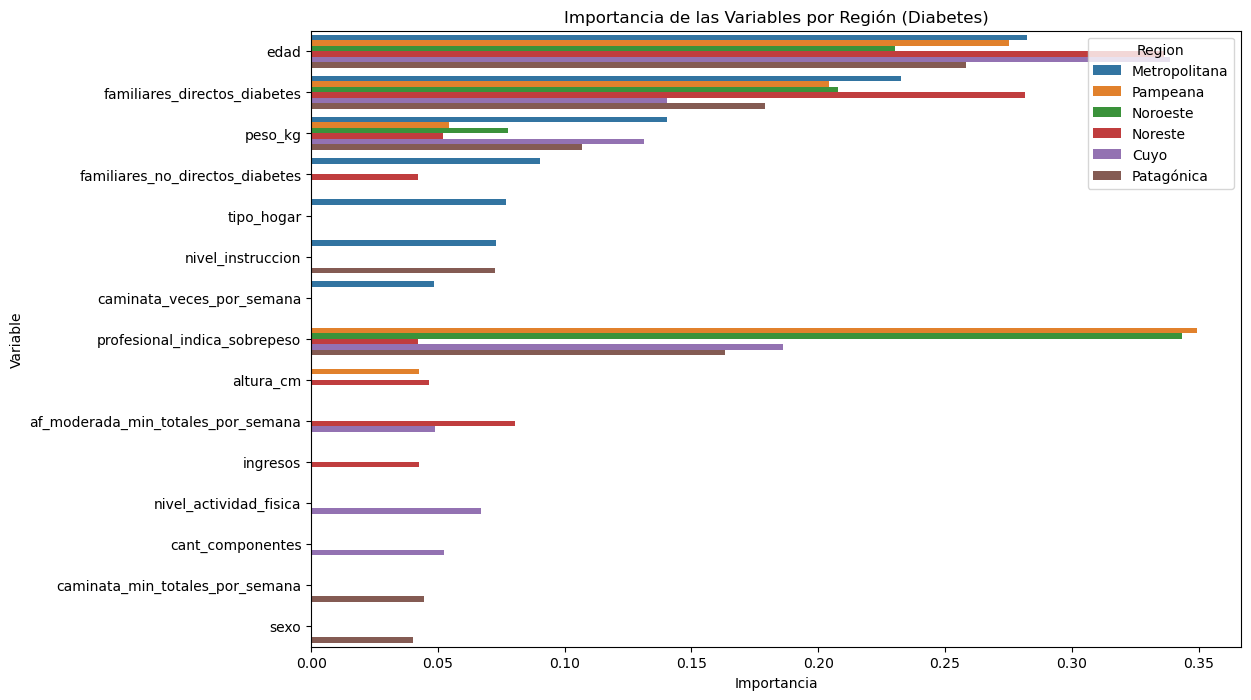

In [118]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_diabetes_df)
plt.title('Importancia de las Variables por Región (Diabetes)')
plt.show()

# Conclusiones causas Diabetes: 
1. Se observan las variables edad y el peso como importantes en la mayoría de las regiones.
2. La variable familiares directos con diabetes resulta significativa en la mayoría de las regiones indicando que existe posiblemente un componente hereditario en la mayoría de los casos de diabetes.
3. En la región de cuyo es importante el nivel de actividad física y la cantidad de compoentes en la familia, similar al Noreste
4. En la regipon Metropolitana, el tiop de hogar parece ser significativo.